# Text2Music Emotion Embedding Demo
You can download pretrained models and relevant files here [link](dropboxlink).

In [2]:
MODEL_PATH = './models'
DATA_PATH = './data'

In [34]:
import os
import torch
import torchaudio
import IPython
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn import metrics
from transformers import DistilBertTokenizer

from src.classification.text_classification.model import MyModel as TextCLS
from src.classification.music_classification.model import MyModel as MusicCLS
from src.regression.text_va.model import MyModel as TextVA
from src.regression.music_va.model import MyModel as MusicVA
from src.regression.text_w2v.model import MyModel as TextW2V
from src.regression.music_w2v.model import MyModel as MusicW2V
from src.metric_learning.model import MyModel as MLModel

from src.classification.music_classification.augmentations import STFT, ComplexNorm, MelScale, AmplitudeToDB

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# moods
alm_moods = ['anger', 'fearful', 'happy', 'sad', 'surprised']
isear_moods = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
audioset_moods = ['angry', 'exciting', 'funny', 'happy', 'sad', 'scary', 'tender']

# audio preprocessing
seq = []
seq.append(STFT(n_fft=512, hop_length=256, win_length=256))
seq.append(ComplexNorm(power=2.0))
seq.append(MelScale(n_mels=128, sample_rate=16000, n_stft=257))
seq.append(AmplitudeToDB())
preprocess = nn.Sequential(*seq)

# mood embeddings
mood_to_vad = pickle.load(open(os.path.join(DATA_PATH, 'tag_to_vad.pkl'), 'rb'))
alm_va = np.array([mood_to_vad[mood][:2] for mood in alm_moods])
isear_va = np.array([mood_to_vad[mood][:2] for mood in isear_moods])
audioset_va = np.array([mood_to_vad[mood][:2] for mood in audioset_moods])
word_to_vec = pickle.load(open(os.path.join(DATA_PATH, 'w2v.pkl'), 'rb'))
alm_w2v = np.array([word_to_vec[mood] for mood in alm_moods])
isear_w2v = np.array([word_to_vec[mood] for mood in isear_moods])
audioset_w2v = np.array([word_to_vec[mood] for mood in audioset_moods])

# constants
INPUT_LENGTH = 80000
NUM_CHUNKS = 4

/home/tiger/.local/lib/python3.7/site-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


## Classification models
### Text classification (Alm's dataset)

In [4]:
# build a model
cls_alm = TextCLS(ndim=64, edim=512, cdim=len(alm_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_alm.load_state_dict(NS)
cls_alm = cls_alm.eval()

In [5]:
def get_alm_cls(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        text_embedding = cls_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[1][0].detach().cpu()
    return alm_moods[text_embedding.argmax()]

In [6]:
text = 'What a pleasant moment. This is amazing.'
get_alm_cls(text)

'happy'

### Text classification (ISEAR dataset)

In [7]:
# build a model
cls_isear = TextCLS(ndim=64, edim=512, cdim=len(isear_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_isear.load_state_dict(NS)
cls_isear = cls_isear.eval()

In [8]:
def get_isear_cls(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        text_embedding = cls_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[1][0].detach().cpu()
    return isear_moods[text_embedding.argmax()]

In [9]:
text = 'He was a bit scared at the unknown sound.'
get_alm_cls(text)

'fearful'

### Music classification (Audioset mood subset)

In [10]:
# build a model
cls_audioset = MusicCLS(ndim=64, edim=64, cdim=len(audioset_moods))

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'cls_audioset.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
cls_audioset.load_state_dict(NS)
cls_audioset = cls_audioset.eval()

In [13]:
def get_multichunk(wav):
    hop = (len(wav) - INPUT_LENGTH) // NUM_CHUNKS
    wav = torch.tensor([wav[i * hop : i * hop + INPUT_LENGTH] for i in range(NUM_CHUNKS)])
    return wav

def get_audioset_cls(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        song_embedding = cls_audioset.spec_to_embedding(spec)[1].detach().cpu().mean(dim=0)
    return audioset_moods[song_embedding.argmax()]

In [14]:
wav = np.load('zzntjwL3s3g.npy')
print(get_audioset_cls(wav))
sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)



tender


## Regression models
### Text V-A regression (Alm's dataset)

In [15]:
# build a model
reg_va_alm = TextVA(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_alm.load_state_dict(NS)
reg_va_alm = reg_va_alm.eval()

In [16]:
def get_alm_va(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        va = reg_va_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return va

happy


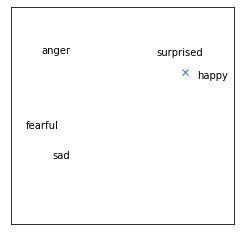

In [17]:
text = 'What a pleasant moment. This is amazing.'
va = get_alm_va(text)
dist = metrics.pairwise.euclidean_distances(alm_va, va)
print(alm_moods[dist.argmin()])

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(alm_moods):
    plt.text(alm_va[i][0], alm_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

### Text V-A regression (ISEAR dataset)

In [18]:
# build a model
reg_va_isear = TextVA(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_isear.load_state_dict(NS)
reg_va_isear = reg_va_isear.eval()

In [19]:
def get_isear_va(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        va = reg_va_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return va

joy


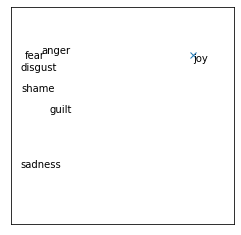

In [20]:
text = 'What a pleasant moment. This is amazing.'
va = get_isear_va(text)
dist = metrics.pairwise.euclidean_distances(isear_va, va)
print(isear_moods[dist.argmin()])

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(isear_moods):
    plt.text(isear_va[i][0], isear_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

### Music V-A regression (Audioset mood subset)

In [21]:
# build a model
reg_va_audioset = MusicVA(ndim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_va_music.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_va_audioset.load_state_dict(NS)
reg_va_audioset = reg_va_audioset.eval()

In [22]:
def get_audioset_va(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        va = reg_va_audioset.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return va

exciting


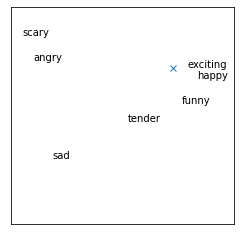

In [23]:
wav = np.load('zzntjwL3s3g.npy')
va = get_audioset_va(wav)
dist = metrics.pairwise.euclidean_distances(audioset_va, va)
print(audioset_moods[dist.argmin()])

sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)

# plot
plt.figure(figsize=(4,4))
for i, mood in enumerate(audioset_moods):
    plt.text(audioset_va[i][0], audioset_va[i][1], mood)
plt.plot(va[0][0], va[0][1], 'x')
plt.xlim([0.0, 1.2])
plt.ylim([0.0, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

### Text W2V regression (Alm's dataset)

In [24]:
# build a model
reg_w2v_alm = TextW2V(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_alm.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_alm.load_state_dict(NS)
reg_w2v_alm = reg_w2v_alm.eval()

In [25]:
def get_alm_w2v(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = reg_w2v_alm.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

In [27]:
text = 'What a pleasant moment. This is amazing.'
emb = get_alm_w2v(text)
sim = metrics.pairwise.cosine_similarity(alm_w2v, emb)
print(alm_moods[sim.argmax()])

happy


### Text W2V regression (ISEAR dataset)

In [28]:
# build a model
reg_w2v_isear = TextW2V(ndim=64, edim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_isear.load_state_dict(NS)
reg_w2v_isear = reg_w2v_isear.eval()

In [29]:
def get_isear_w2v(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = reg_w2v_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

In [30]:
text = 'What a pleasant moment. This is amazing.'
emb = get_isear_w2v(text)
sim = metrics.pairwise.cosine_similarity(isear_w2v, emb)
print(isear_moods[sim.argmax()])

joy


### Music W2V regression (Audioset mood subset)

In [31]:
# build a model
reg_w2v_audioset = MusicW2V(ndim=64)

# load state dict
S = torch.load(os.path.join(MODEL_PATH, 'reg_w2v_music.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
reg_w2v_audioset.load_state_dict(NS)
reg_w2v_audioset = reg_w2v_audioset.eval()

In [32]:
def get_audioset_w2v(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        emb = reg_w2v_audioset.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return emb

In [33]:
wav = np.load('zzntjwL3s3g.npy')
emb = get_audioset_w2v(wav)
sim = metrics.pairwise.cosine_similarity(audioset_w2v, emb)
print(audioset_moods[sim.argmax()])

sf.write('temp.wav', wav, 16000)
IPython.display.Audio('temp.wav', rate=16000)

scary


## Metric learning models
### Three branch text-to-music (Alm's dataset - Audioset mood subset)

### Three branch text-to-music (ISEAR dataset - Audioset mood subset)

In [44]:
# build a model
ml_isear = MLModel()

# load state dict
S = torch.load(os.path.join(MODEL_PATH, '3b_isear.ckpt'))['state_dict']
NS = {k[6:]: S[k] for k in S.keys() if (k[:5] == 'model')}
ml_isear.load_state_dict(NS)
ml_isear = ml_isear.eval()

# get tag embeddings
concat_moods = list(set(['text_' + m for m in isear_moods] + ['music_' + m for m in audioset_moods]))
concat_moods.sort()
with torch.no_grad():
    mood_embs = ml_isear.tag_to_embedding(torch.tensor([word_to_vec[mood.split('_')[1]] for mood in concat_moods]))

In [45]:
def text_to_emb(text):
    tokens = tokenizer([text, text], return_tensors='pt', padding=True, truncation=True) # made a list of the text to avoid batch_normalization issue
    with torch.no_grad():
        emb = ml_isear.text_to_embedding(tokens['input_ids'], tokens['attention_mask'])[0].detach().cpu().unsqueeze(0)
    return emb

def wav_to_emb(wav):
    wav = get_multichunk(wav.astype('float32'))
    spec = preprocess(wav)
    with torch.no_grad():
        emb = ml_isear.spec_to_embedding(spec).detach().cpu().mean(dim=0).unsqueeze(0)
    return emb

In [56]:
text = 'When I encounter to an unpleasant situation.'
emb = text_to_emb(text)
sim = metrics.pairwise.cosine_similarity(mood_embs[-7:], emb)
print(concat_moods[-7:][sim.argmax()])
sim = metrics.pairwise.cosine_similarity(mood_embs[:7], emb)
print(concat_moods[:7][sim.argmax()])

text_shame
music_sad
